#Activity 19

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import random

url = 'https://raw.githubusercontent.com/pango3001/AI/main/project/adult1.csv'

#numpy darray
data = np.genfromtxt(url, delimiter=",", skip_header = True) 

#panda dataframe
dataset = pd.read_csv(url, delimiter=',')
dataset.head()

,age,workclass,fnlwgt,education,educationNum,maritalStatus,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,country,earnings
0,39,3,77516,13,13,0,0,1,1,2174,0,40,1,0
1,50,2,83311,13,13,1,1,1,1,0,0,13,1,0
2,38,1,215646,10,9,2,0,1,1,0,0,40,1,0
3,53,1,234721,6,7,1,1,2,1,0,0,40,1,0
4,28,1,338409,13,13,1,2,2,0,0,0,40,14,0


In [2]:
# Shuffle the dataset
# NOTE: shuffle dataframe in-place and reset the index
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Convert Pandas Dataframe to Numpy dArray
dataset_np = dataset.values
X = dataset.drop('age', axis='columns').values
Y = dataset['age'].values

###Sizes of the Splits

In [3]:
# Index for 30% --- Normal
index_30percent = int(0.3 * len(dataset_np[:, 0]))
print(index_30percent)

# Index for 2%
index_2percent = int(0.02 * len(dataset_np[:, 0]))
print(index_2percent)

# Index for 98%
index_98percent = int(0.98 * len(dataset_np[:, 0]))
print(index_98percent)

9768
651
31909


## Datasets

### Normal Validation Dataset

In [4]:
# Split into training and validation
XVALID = X[:index_30percent, :]
YVALID = Y[:index_30percent]

XTRAIN = X[index_30percent:, :]
YTRAIN = Y[index_30percent:]

print(XTRAIN.shape)
print(YTRAIN.shape)

print(XVALID.shape)
print(YVALID.shape)


## Mean normalization
min = XTRAIN.min(axis = 0) 
max = XTRAIN.max(axis = 0) 
mean = XTRAIN.mean(axis = 0)
XTRAIN = (XTRAIN - mean) / (max - min)
XVALID = (XVALID - mean) / (max - min)

## Rescaling
Ymax = YTRAIN.max()
YTRAIN = YTRAIN / Ymax
YVALID = YVALID / Ymax

(22793, 13)
(22793,)
(9768, 13)
(9768,)


## Build a neural network

###No Early Stopping

In [5]:
model = Sequential()
model.add(Dense(13, input_dim=len(XTRAIN[0, :]), activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:
# Normal Dataset
import time
model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
start_time = time.time()
history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 256, batch_size=128, verbose=1)
noCallBackTime = time.time() - start_time

Epoch 1/256
179/179 [==============================] - 1s 4ms/step - loss: 0.0226 - mae: 0.1229 - val_loss: 0.0177 - val_mae: 0.1061
Epoch 2/256
179/179 [==============================] - 0s 3ms/step - loss: 0.0165 - mae: 0.1017 - val_loss: 0.0161 - val_mae: 0.0995
Epoch 3/256
179/179 [==============================] - 0s 3ms/step - loss: 0.0155 - mae: 0.0978 - val_loss: 0.0155 - val_mae: 0.0990
Epoch 4/256
179/179 [==============================] - 1s 3ms/step - loss: 0.0149 - mae: 0.0960 - val_loss: 0.0149 - val_mae: 0.0966
Epoch 5/256
179/179 [==============================] - 0s 3ms/step - loss: 0.0145 - mae: 0.0946 - val_loss: 0.0147 - val_mae: 0.0945
Epoch 6/256
179/179 [==============================] - 1s 3ms/step - loss: 0.0142 - mae: 0.0934 - val_loss: 0.0144 - val_mae: 0.0940
Epoch 7/256
179/179 [==============================] - 0s 3ms/step - loss: 0.0140 - mae: 0.0926 - val_loss: 0.0142 - val_mae: 0.0930
Epoch 8/256
179/179 [==============================] - 1s 3ms/step - 

In [7]:
print(history.params)

{'verbose': 1, 'epochs': 256, 'steps': 179}


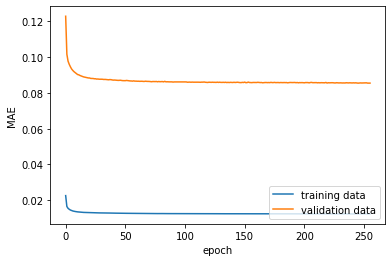

In [8]:
# Plot the learning curves (loss/accuracy/MAE)
plt.plot(history.history['loss']) # replace with accuracy/MAE
plt.plot(history.history['mae']) # replace with val_accuracy, etc.
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error

importance_feature_columns = []
importance_feature = []
for index in range(1, dataset.shape[1]):
    ## Get the column
    X = dataset[dataset.columns[index]].values
    Y = dataset['age'].values

    ## Index for 30%
    index_30percent = int(0.3 * len(dataset_np[:, 0]))

    ## Split into training and validation
    XVALID = X[:index_30percent]
    YVALID = Y[:index_30percent]
    
    XTRAIN = X[index_30percent:]
    YTRAIN = Y[index_30percent:]

    ## Mean normalization
    min = XTRAIN.min(axis = 0) 
    max = XTRAIN.max(axis = 0) 
    mean = XTRAIN.mean(axis = 0)
    XTRAIN = (XTRAIN - mean) / (max - min)
    XVALID = (XVALID - mean) / (max - min)

    ## Rescaling
    Ymax = YTRAIN.max()
    YTRAIN = YTRAIN / Ymax
    YVALID = YVALID / Ymax

    ## Callback
    callback_a = ModelCheckpoint(filepath = "feature_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    ## Model
    modelImp = Sequential()
    modelImp.add(Dense(13, input_dim=1, activation='relu'))
    modelImp.add(Dense(7, activation='relu'))
    modelImp.add(Dense(1, activation='linear'))

    ## Compile Model
    modelImp.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
    history = modelImp.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=0)
    
    ## Store MAE
    prediction = modelImp.predict(XVALID, verbose=0)
    mae = mean_absolute_error(YVALID, prediction)
    importance_feature_columns.append(dataset.columns[index])
    importance_feature.append(mae)
# ~~~

print(importance_feature_columns)
print(importance_feature)

['workclass', 'fnlwgt', 'education', 'educationNum', 'maritalStatus', 'relationship', 'race', 'sex', 'capitalGain', 'capitalLoss', 'hoursPerWeek', 'country', 'earnings']
[0.12061698880809021, 0.1234926305231921, 0.12128439813076673, 0.12126368178043335, 0.09845253330170539, 0.10630889437846593, 0.12527869854680737, 0.12388272191781682, 0.12381184521433013, 0.1239405013758488, 0.12253916953774338, 0.12541068834297997, 0.12155699302858583]


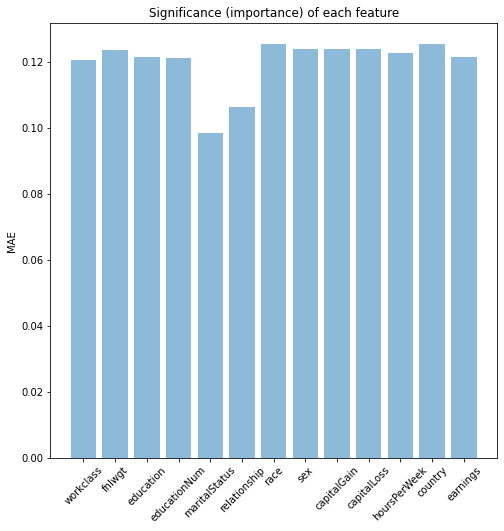

In [10]:
y_pos = np.arange(len(importance_feature_columns))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, importance_feature, align='center', alpha=0.5)
plt.xticks(y_pos, importance_feature_columns, fontsize=10, rotation=45)
plt.ylabel('MAE')
plt.title('Significance (importance) of each feature')

plt.show()

###Early Stopping

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# File name must be in quotes
callback_a = ModelCheckpoint(filepath = "your_model.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)

# The patience value can be 10, 20, 100, etc. depending on when your model starts to overfit
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

model2 = Sequential()
model2.add(Dense(13, input_dim=len(XTRAIN[0, :]), activation='relu'))
model2.add(Dense(7, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

IndexError: ignored

In [ ]:
model2.compile(loss='mse', optimizer = 'adam', metrics=['mae'])

start_time = time.time()
history = model2.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs=256, batch_size=128, callbacks = [callback_a, callback_b]) 
callBackTime = time.time() - start_time

In [ ]:
# File name must be in quotes
model2.load_weights("your_model.hdf5")

In [ ]:
# Plot the learning curves (loss/accuracy/MAE)
plt.plot(history.history['loss']) # replace with accuracy/MAE
plt.plot(history.history['mae']) # replace with val_accuracy, etc.
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [ ]:
print(callBackTime)

In [ ]:
print(noCallBackTime)

In [ ]:
percentFaster = noCallBackTime/callBackTime
print(percentFaster)

a. Almost always, training with early stopping finishes faster (because it stops early). Approximately, how long does it take for your training to finish with and without early stopping?

About 27.9% faster with early stopping


b. When model checkpointing, your checkpointed model will almost always be more accurate on the validation set. What is the MAE on the Validation set with and without model checkpointing?

Early stopping MAE: 0.0860

Normal MAE: 0.0858
